<a href="https://colab.research.google.com/github/rpandya5/gaitanalysis/blob/main/training/training_v3(Raw_Sensor_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training v3

Taking in Raw sensor data as inputs given the CNN-LSTM architecture's ability to recognise temporal dependencies in our data.

**Notes for the training of model version 1 in this notebook:**

In the architectures, we have changed the stride and kernel size of the first CNN Layer making it larger as this acts as the window which slides across the sensor data (keeping the 2 second window size with 1 second overlap in mind)

Also for this particular testing, we chose the second set of accelerometer readings as it has a smaller range and is more similar to phone data's range.

We also downsampled the 200Hz of the SisFall dataset to 10 Hz to match the Phone Collected Data. This was also done keeping in mind that most mobile phones cannot produce data at 200Hz due to memory resource management.

We also scaled our data using MinMax Scaler to keep the datasets on the same scale.



In [ ]:
#Loading libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import os

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Loading SisFall
import os

sisdata = []
sislabels = []
k = 1
for dir, _, files in os.walk('/content/gdrive/MyDrive/Preprocessed Data'):
  for file in files:
    file_df = pd.read_csv(os.path.join(dir, file))
    file_df = file_df.drop(['Timestamp', 'X_Acc_1', 'Y_Acc_1', 'Z_Acc_1'], axis=1)
    file_df = file_df.iloc[:,[3,4,5,0,1,2]]
    file_np = np.array(file_df)
    file_np = np.array([file_np[i] for i in range(0, len(file_np)-20, 20)])
    file_np = file_np[:150]
    if len(file_np)<150:
      file_np = np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_np), 1)))))
    sisdata.append(file_np)
    if file[0] == 'F':
      sislabels.append(1)
    else:
      sislabels.append(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.vstack(np.array(sisdata)))

MinMaxScaler()

In [ ]:
sisdata_scaled = np.array([scaler.transform(np.array(sisdata[i])) for i in range(len(sisdata))])

In [ ]:
#Getting train, val, test data sets
import random
siscombined = (listOfTuples(torch.from_numpy(sisdata_scaled).to(torch.float), torch.from_numpy(np.array(sislabels)).to(torch.float)))
random.shuffle(siscombined)

In [ ]:
train_data = siscombined[:3600]
val_data = siscombined[3600:4050]
test_data = siscombined[4050:]

In [ ]:
phone_data = []
phone_labels = []

In [ ]:
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data/ADLs Phone'):
  for file in files:
    activity = file[:3]
    file_df = pd.read_csv(os.path.join(dir, file))
    cols = file_df.columns
    file_df['X_Acc'] = file_df['accelerometer_x'] * (-1)
    file_df['Y_Acc'] = file_df['accelerometer_y'] * (-1)
    file_df['Z_Acc'] = file_df['accelerometer_z'] * -1
    file_df['X_Gyro'] = file_df['gyroscope_x'] * -180/3.14
    file_df['Y_Gyro'] = file_df['gyroscope_y'] * -180/3.14
    file_df['Z_Gyro'] = file_df['gyroscope_z'] * -180/3.14
    file_df = file_df.drop(cols, axis=1)
    file_df_np = np.array(file_df)
    # file_df_np = [np.vstack(file_df_np[i],  (10, 1)) for i in range(len(file_df_np))]
    if len(file_df_np)>150:
      file_df_np = file_df_np[:150]
    elif len(file_df_np)<150:
      file_df_np = np.vstack((file_df_np, np.tile(file_df_np[-1], (150-len(file_df_np), 1))))
    phone_data.append(file_df_np)
    phone_labels.append(0)

In [ ]:
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data/Falls Phone'):
  for file in files:
    activity = file[:3]
    file_df = pd.read_csv(os.path.join(dir, file))
    cols = file_df.columns
    file_df['X_Acc'] = file_df['accelerometer_x'] * (-1)
    file_df['Y_Acc'] = file_df['accelerometer_y'] * (-1)
    file_df['Z_Acc'] = file_df['accelerometer_z'] * -1
    file_df['X_Gyro'] = file_df['gyroscope_x'] * -180/3.14
    file_df['Y_Gyro'] = file_df['gyroscope_y'] * -180/3.14
    file_df['Z_Gyro'] = file_df['gyroscope_z'] * -180/3.14
    file_df = file_df.drop(cols, axis=1)
    file_df_np = np.array(file_df)
    # file_df_np = [np.vstack(file_df_np[i],  (10, 1)) for i in range(len(file_df_np))]
    if len(file_df_np)>150:
      file_df_np = file_df_np[20:170]
    elif len(file_df_np)<150:
      file_df_np = np.vstack((file_df_np, np.tile(file_df_np[-1], (150-len(file_df_np), 1))))
    phone_data.append(file_df_np)
    phone_labels.append(1)

In [ ]:
phone_data_scaled = scaler.transform(np.vstack(np.array(phone_data))).reshape((97, 150, 6))

In [ ]:
phone_data_combined = (listOfTuples((torch.from_numpy(phone_data_scaled)).to(torch.float), torch.from_numpy(np.array(phone_labels)).to(torch.float)))
random.shuffle(phone_data_combined)

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size):
    super(Model, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 16 filters, kernel size 20, stride=10, relu, batch norm, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=20, stride=10, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 32 filters, kernel size 2, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 64 filters, kernel size 2, relu, batch norm, maxpooling size 2, stride=2
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride = 2, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size=2)
    )

    # LSTM LAYERS

    # 256 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=64, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    # self.lstm_3 = nn.LSTM(input_size=64, hidden_size=25, batch_first=True)

    # # 100 input from lstm1, 100 units, return false
    # self.lstm_4 = nn.LSTM(input_size=25, hidden_size=10, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.25),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)
    # # lstm_out, _ = self.lstm_3(lstm_out)
    # # lstm_out, _ = self.lstm_4(lstm_out)



    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
#Helper Functions
def plot_train_val(epoch_list, train_loss, val_loss, title):
    # Plotting

  fig, ax = plt.subplots(figsize=(6, 5))

  plt.title(title+" Curve")

  colors = ["#8D99AE", "#EF233C"]
  # Plot the baseline text
  plt.text(
    epoch_list[-1] * 1.01,
    train_loss[-1],
    "Training " + title,
    color=colors[0],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  plt.text(
    epoch_list[-1] * 1.01,
    val_loss[-1],
    "Validation " + title,
    color=colors[1],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  # Hide the all but the bottom spines (axis lines)
  ax.spines["right"].set_visible(False)
  #ax.spines["left"].set_visible(False)
  ax.spines["top"].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position("left")
  ax.xaxis.set_ticks_position("bottom")
  #ax.spines["bottom"].set_bounds(min(x), max(x))


  plt.plot(epoch_list, train_loss, label="Train", color = colors[0], linewidth = 2)
  plt.plot(epoch_list, val_loss, label="Validation", color = colors[1], linewidth = 2)
  plt.xlabel("Epoch")
  plt.ylabel(title)
  plt.legend(loc='best')
  plt.show()

def train(model, data, val_data, batch_size = 64, lr = 0.01, epoch_num = 100):
  #train_queue = tf.train.slice_input_producer([data, train_labels],num_epochs=epoch_num,batch_size = batch_size,shuffle=True)

  train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size)
  #val_queue = tf.train.slice_input_producer([val_data, val_labels], num_epochs=epoch_num,batch_size = batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)

  criterion = nn.BCEWithLogitsLoss()
  optimizer  = torch.optim.Adam(model.parameters(),lr=lr)

  train_err, val_err, train_acc, val_acc = [], [], [], []

  train_t1_err, train_t2_err, val_t1_err, val_t2_err = [], [], [], []

  v_out = []

  epoch_list = range(epoch_num)
  num = 0

  train_loss = []
  val_loss = []
  loss_temp = []

  for epoch in epoch_list:

    error = 0
    count = 0
    t1_err = 0
    t2_err = 0

    for sample, labels in iter(train_loader):
      count += 1
      out = model(sample)         # Compute the output
      loss = criterion(out, labels) # Compute the total loss
      loss.backward()               # Backward pass
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # PyTorch clean up

      # Recalculating the out for the updated model step.
      out = model(sample)
      loss = criterion(out, labels)
      # Save the current training information
      loss_temp.append(float(loss)/batch_size)
      out = torch.sigmoid(out) # Gets the decimal estimations of fall / no fall
      estimate = torch.round(out) # Rounds each estimate to 1 or 0 --> fall or no fall

      type1_error = F.relu(estimate - labels) # Gets all the type 1 errors (predicted fall with no fall)
      type2_error = F.relu(labels - estimate) # Gets all the type 2 errors (predicted no fall with fall)


      diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
      temp = torch.sum(diff) # Sums all the error estimates
      error = temp.item() + error
      t1_err += torch.sum(type1_error).item()
      t2_err += torch.sum(type2_error).item()

    train_acc.append(1 - error/len(data))
    train_err.append(error/len(data))
    train_loss.append(sum(loss_temp)/len(loss_temp))

    train_t1_err.append(t1_err/len(data))
    train_t2_err.append(t2_err/len(data))
    error = 0
    t1_err = 0
    t2_err = 0

    # computing the error and accuracy on a validation set
    loss_temp = []
    count = 0
    error = 0
    v_out = torch.tensor([])
    for sample, labels in iter(val_loader):
      count += 1
      out = model(sample)
      loss = criterion(out, labels)
      out = torch.sigmoid(out) # Gets the decimal estimations of fall / no fall
      estimate = torch.round(out) # Rounds each estimate to 1 or 0 --> fall or no fall
      diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
      temp = torch.sum(diff) # Sums all the error estimates
      error = temp.item() + error

      loss_temp.append(float(loss)/batch_size)
      type1_error = F.relu(estimate - labels) # Gets all the type 1 errors (predicted fall with no fall)
      type2_error = F.relu(labels - estimate) # Gets all the type 2 errors (predicted no fall with fall)
      t1_err += torch.sum(type1_error).item()
      t2_err += torch.sum(type2_error).item()
      v_out = torch.cat((v_out, out))


    val_err.append(error/len(val_data))
    val_acc.append(1 - error/len(val_data))
    val_loss.append(sum(loss_temp)/len(loss_temp))

    val_t1_err.append(t1_err/len(val_data))
    val_t2_err.append(t2_err/len(val_data))

    print("\n\nEpoch ", epoch, "\nTraining Loss         : ",round(train_loss[-1],2), "\nTraining Accuracy     : ", round(train_acc[-1],2), "\nValidation Loss       : ", round(val_loss[-1],2), "\nValidation Accuracy   : ", round(val_acc[-1],2))
    # print(get_acc(model, phone_data_combined, batch_size))

  v_out = v_out.view(-1).cpu().detach().numpy()
  plot_train_val(epoch_list, train_loss, val_loss, "Loss")
  plot_train_val(epoch_list, train_acc, val_acc, "Accuracy")
  plot_train_val(epoch_list, train_err, val_err, "Error")

  return v_out

def get_labels(data):
  #Returns the labels
  list = []
  for elem in data:
    list.append(int(elem[-1]))
  return list

def listOfTuples(l1, l2):
  #Merging
  return list(map(lambda x, y:(x,y), l1, l2))

def get_acc(model, data, batch_size):
  correct = 0
  total = 0
  error = 0
  out_list = torch.tensor([])
  for img, labels in torch.utils.data.DataLoader(data, batch_size = batch_size):
    output = model(img)
    output = torch.sigmoid(output) # Gets the decimal estimations of fall / no fall
    estimate = torch.round(output) # Rounds each estimate to 1 or 0 --> fall or no fall
    diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
    temp = torch.sum(diff) # Sums all the error estimates
    error = temp.item() + error

    out_list = torch.cat((out_list, output))

  label_list = get_labels(data)
  out_list = out_list.view(-1).cpu().detach().numpy()
  out_list = [round(i) for i in out_list]
  confusion_matrix_2 = metrics.confusion_matrix(label_list, out_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])

  cm_display.plot()
  plt.show()

  return 1 - error / len(data)


## Hyperparameter Tuning

## Version 1

Batch Size= 1

Layers- 3 CNN  Layers(16 32 64 feature depth) + 2 LSTM Layers + 2 Linear Layers

Learning Rate- 0.001

Epochs- 3

Results- Overfits sisfall easily
         Model only guesses ADL for Phone collected Data


In [ ]:
model1 = Model(6)



Epoch  0 
Training Loss         :  0.1 
Training Accuracy     :  0.97 
Validation Loss       :  0.04 
Validation Accuracy   :  0.99


Epoch  1 
Training Loss         :  0.05 
Training Accuracy     :  0.98 
Validation Loss       :  0.06 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.04 
Training Accuracy     :  0.99 
Validation Loss       :  0.04 
Validation Accuracy   :  1.0


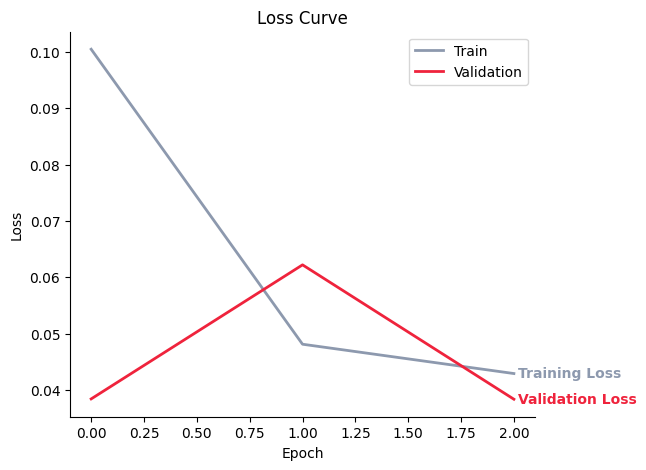

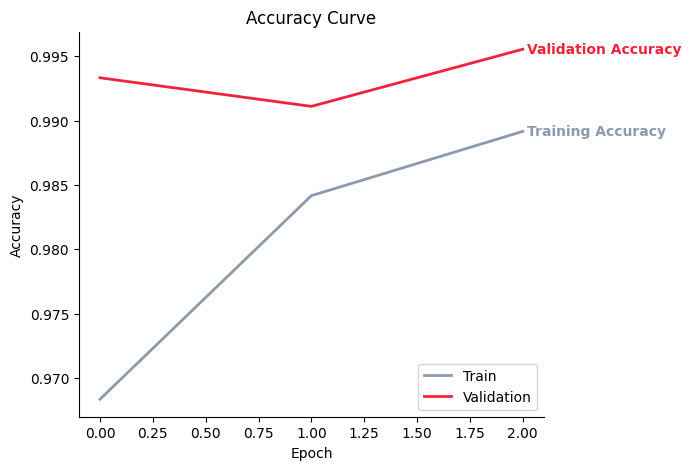

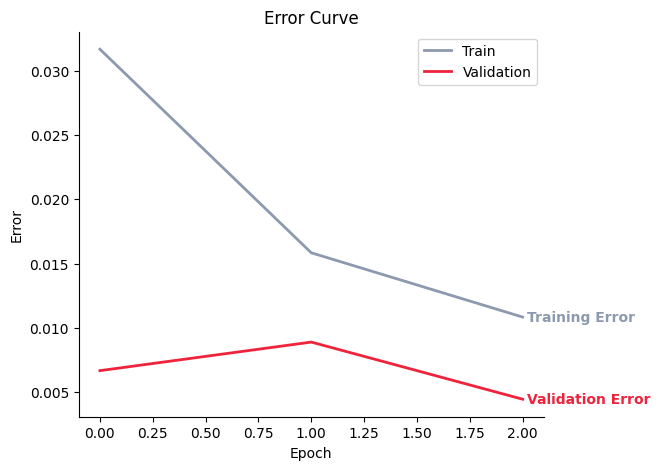

array([9.99203980e-01, 3.21971889e-08, 1.79830647e-06, 2.20010088e-06,
       9.99684811e-01, 4.81670678e-01, 8.33190050e-09, 3.31511205e-06,
       9.88027334e-01, 1.29855252e-05, 9.99983668e-01, 1.23516699e-08,
       1.75659210e-07, 9.99679565e-01, 9.99783576e-01, 9.99888778e-01,
       9.90143418e-01, 9.99219418e-01, 8.42650110e-08, 4.64311185e-08,
       9.99831676e-01, 2.32091570e-05, 2.42794215e-07, 6.32103765e-04,
       9.99923825e-01, 9.99836922e-01, 2.28390832e-06, 4.38767529e-08,
       3.23279437e-06, 9.99754727e-01, 1.04564663e-06, 7.51886716e-07,
       7.64879005e-08, 4.26718884e-07, 6.42229497e-05, 5.31423166e-06,
       4.80136748e-07, 1.80114540e-07, 8.97031963e-01, 1.93798087e-06,
       9.92210984e-01, 2.78469247e-06, 9.99945402e-01, 6.41648938e-08,
       9.82575178e-01, 3.36156110e-04, 8.35349709e-08, 5.75732422e-08,
       5.71814525e-08, 9.96609986e-01, 9.99917269e-01, 2.17885643e-09,
       9.95033145e-01, 9.99863744e-01, 9.99760807e-01, 9.99778450e-01,
      

In [ ]:
train(model1, train_data, val_data, 1, 0.001, 3)

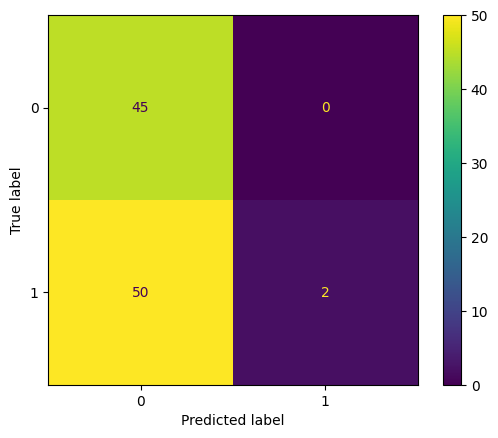

0.48453608247422686

In [ ]:
get_acc(model1, phone_data_combined, 1)

## Version 2
Changed batch size to 100 for faster training and preventing overfitting

Reduced epochs to 2 to prevent overfitting

Outputs: Model Definitely Learns better (no longer just ADL predictions)
Accuracy still low

In [ ]:
model2 = Model(6)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.96 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


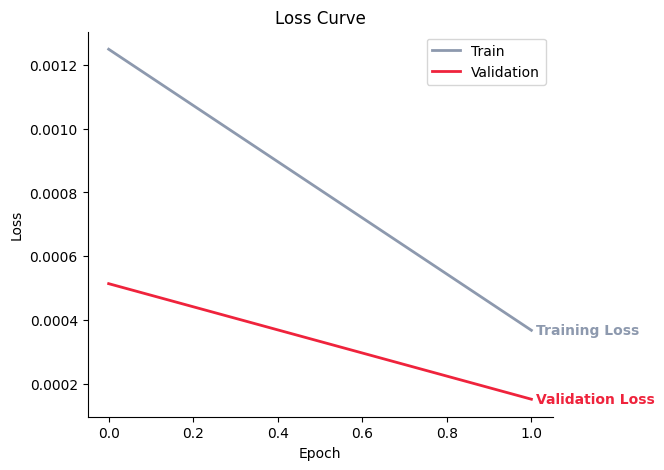

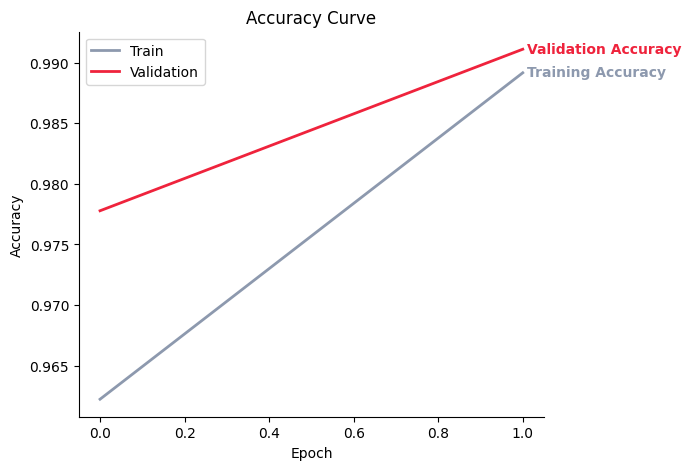

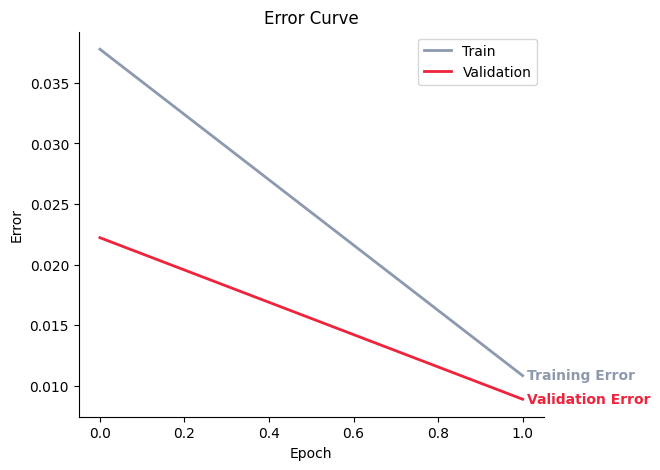

array([9.99881625e-01, 2.39611836e-05, 6.67329412e-04, 1.49459273e-04,
       9.99816597e-01, 8.10549140e-01, 8.11793943e-05, 2.66314764e-05,
       9.99967575e-01, 2.16743592e-05, 9.99994636e-01, 8.52427183e-05,
       5.60227549e-04, 9.99844193e-01, 9.98897791e-01, 9.99997139e-01,
       9.96942699e-01, 9.99998569e-01, 1.83377160e-05, 2.50779034e-04,
       9.99908686e-01, 4.13115995e-05, 1.52249495e-05, 1.32163914e-04,
       9.99845028e-01, 9.99985218e-01, 1.88756894e-05, 7.26456565e-05,
       1.43015961e-04, 9.99930739e-01, 3.12965334e-04, 3.34371034e-05,
       5.65625160e-05, 2.80182649e-05, 4.30051114e-05, 1.89090570e-05,
       1.20666600e-05, 4.79777555e-05, 9.95939732e-01, 6.58830162e-04,
       9.99830246e-01, 9.99942303e-01, 9.99820888e-01, 6.16834150e-05,
       9.99765575e-01, 1.08841683e-04, 1.92823005e-04, 1.04461378e-05,
       3.67665234e-05, 9.99989271e-01, 9.99990582e-01, 2.26086377e-05,
       9.84622180e-01, 9.99900818e-01, 9.99934673e-01, 9.99997735e-01,
      

In [ ]:
train(model2, train_data, val_data, 100, 0.01, 2)

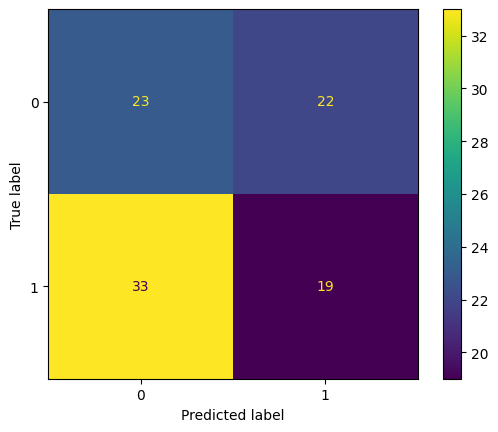

0.4329896907216495

In [ ]:
get_acc(model2, phone_data_combined, 100)

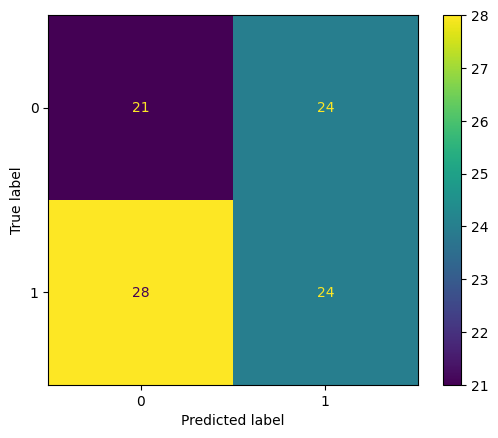

0.4639175257731959

In [ ]:
get_acc(model2, phone_data_combined, 5)

## Version 3
Swapped SisFall and Phone Collected Data as Test and Training sets respectively to see effect on training. Also reduced batch size for SisFall.

Output: Model performs poorly on both SisFall oweing to overfitting on the Phone Collected Data due to small number of samples (as expected)

In [ ]:
model4 = Model(6)



Epoch  0 
Training Loss         :  0.13 
Training Accuracy     :  0.6 
Validation Loss       :  0.14 
Validation Accuracy   :  0.43


Epoch  1 
Training Loss         :  0.11 
Training Accuracy     :  0.89 
Validation Loss       :  0.14 
Validation Accuracy   :  0.57


Epoch  2 
Training Loss         :  0.06 
Training Accuracy     :  0.98 
Validation Loss       :  0.2 
Validation Accuracy   :  0.71


Epoch  3 
Training Loss         :  0.03 
Training Accuracy     :  1.0 
Validation Loss       :  0.23 
Validation Accuracy   :  0.71


Epoch  4 
Training Loss         :  0.03 
Training Accuracy     :  1.0 
Validation Loss       :  0.22 
Validation Accuracy   :  0.71


Epoch  5 
Training Loss         :  0.02 
Training Accuracy     :  1.0 
Validation Loss       :  0.26 
Validation Accuracy   :  0.71


Epoch  6 
Training Loss         :  0.03 
Training Accuracy     :  1.0 
Validation Loss       :  0.31 
Validation Accuracy   :  0.71


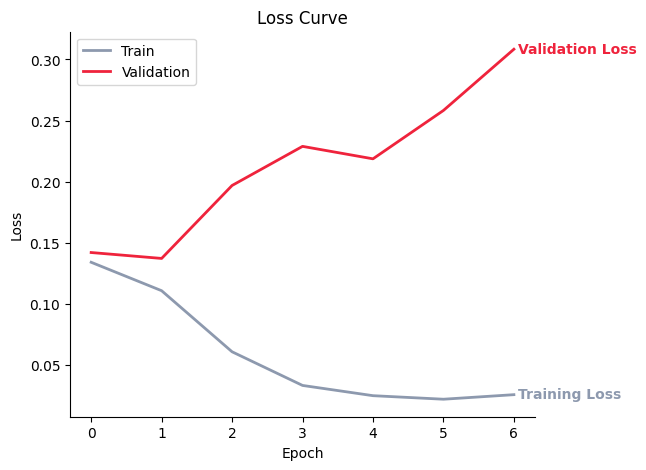

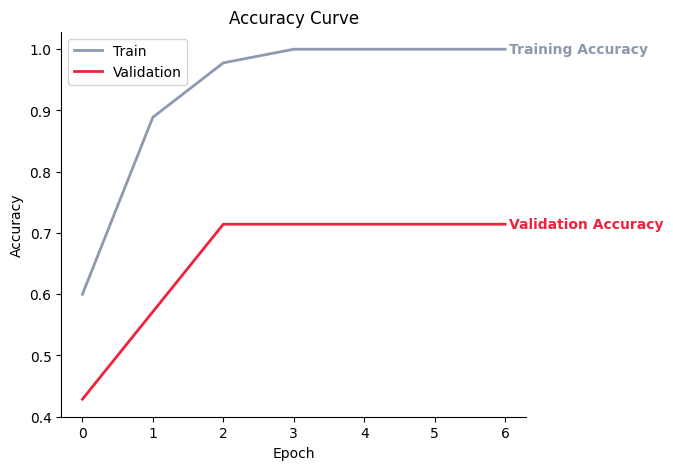

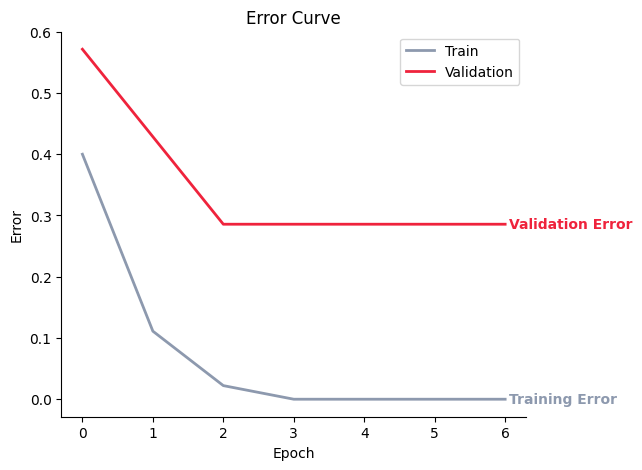

array([3.1339985e-03, 9.9996197e-01, 3.3211049e-03, 9.9862552e-01,
       9.9466056e-01, 3.7587102e-04, 9.9995530e-01], dtype=float32)

In [ ]:
train(model4, phone_data_combined[:90], phone_data_combined[90:] , 5, 0.001, 7)

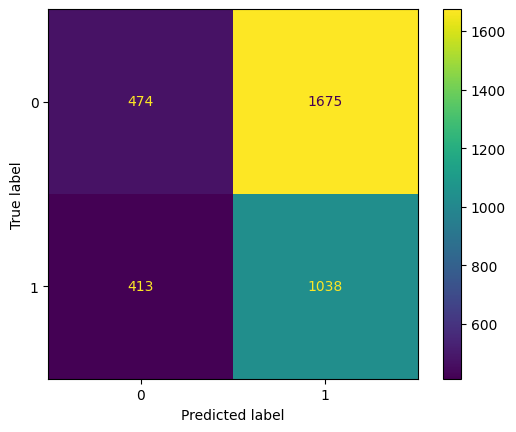

0.42000000000000004

In [ ]:
get_acc(model4, train_data, 5)

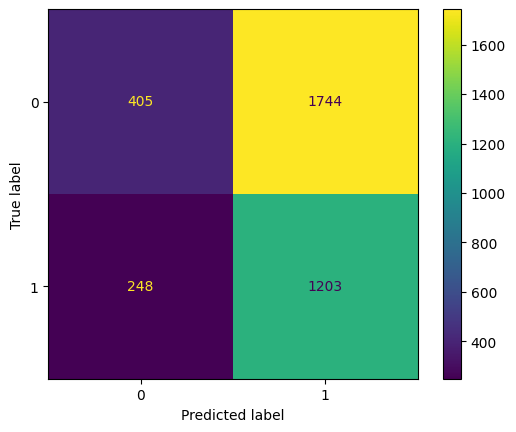

0.44666666666666666

In [ ]:
get_acc(model4, train_data, 2)

## Version 4

Removed LSTM Layers to see impact on training

Output: Improved Model performance seen

In [ ]:
class Model2(nn.Module):
  def __init__(self, input_size):
    super(Model2, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 16 filters, kernel size 3, relu, batch norm, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=20, stride=10, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 32 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 64 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride = 2, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size=2)
    )

    # LSTM LAYERS

    # # 256 input from cnn, 100 units
    # self.lstm_1 = nn.LSTM(input_size=64, hidden_size=100, batch_first=True)

    # # 100 input from lstm1, 100 units, return false
    # self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    # self.lstm_3 = nn.LSTM(input_size=64, hidden_size=25, batch_first=True)

    # # 100 input from lstm1, 100 units, return false
    # self.lstm_4 = nn.LSTM(input_size=25, hidden_size=10, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(64, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.25),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    # lstm_out, _ = self.lstm_1(lstm_in)
    # lstm_out, _ = self.lstm_2(lstm_out)
    # # lstm_out, _ = self.lstm_3(lstm_out)
    # # lstm_out, _ = self.lstm_4(lstm_out)



    fully_connected_in = lstm_in.view(-1, 64) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
model3 = Model2(6)



Epoch  0 
Training Loss         :  0.01 
Training Accuracy     :  0.96 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


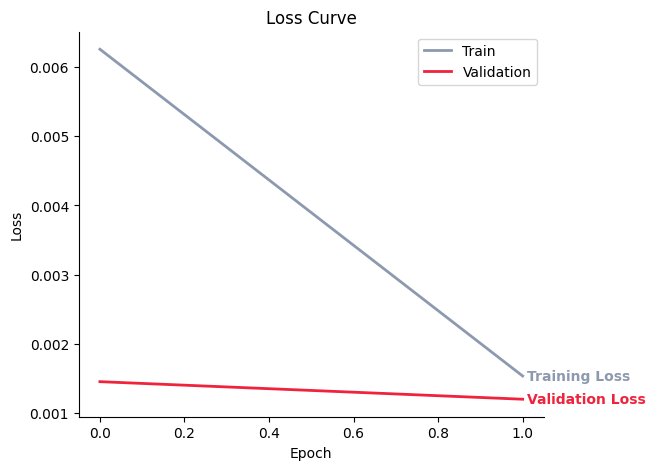

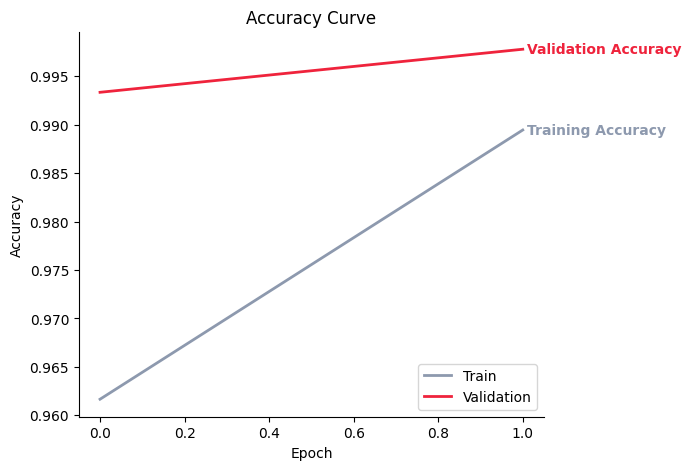

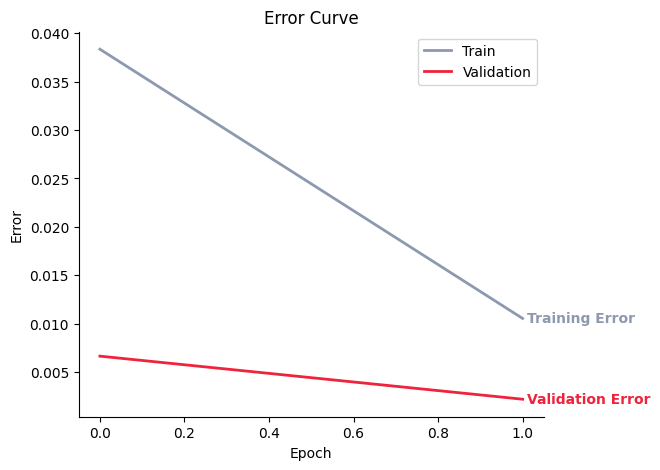

array([9.99999404e-01, 2.40873342e-04, 6.35532779e-04, 3.04564222e-04,
       9.89202559e-01, 1.15457296e-01, 3.65961547e-04, 4.31005901e-04,
       9.69492912e-01, 1.91402098e-04, 9.99985456e-01, 2.12318118e-04,
       1.42077959e-04, 9.99870539e-01, 9.73946273e-01, 9.99957919e-01,
       9.92911398e-01, 9.99875069e-01, 1.77469425e-04, 9.38809942e-04,
       9.99997735e-01, 3.62784043e-03, 6.44822139e-04, 1.31701923e-03,
       9.99973774e-01, 9.99851584e-01, 7.28867832e-04, 1.67800509e-03,
       1.10113742e-02, 9.99996781e-01, 5.86853479e-04, 1.01007428e-03,
       9.39941593e-03, 4.36899997e-03, 6.59971149e-04, 1.95042929e-03,
       3.01352411e-04, 3.54333286e-04, 9.83161330e-01, 6.60170277e-04,
       9.96908844e-01, 5.30273712e-04, 9.95895267e-01, 7.27635226e-04,
       9.62366462e-01, 1.02001490e-04, 5.17928311e-05, 4.28069674e-04,
       6.17536949e-04, 9.99982119e-01, 9.99995232e-01, 2.47221091e-04,
       9.81298089e-01, 9.99983668e-01, 9.99980688e-01, 9.99567688e-01,
      

In [ ]:
train(model3, train_data, val_data, 20, 0.001, 2)

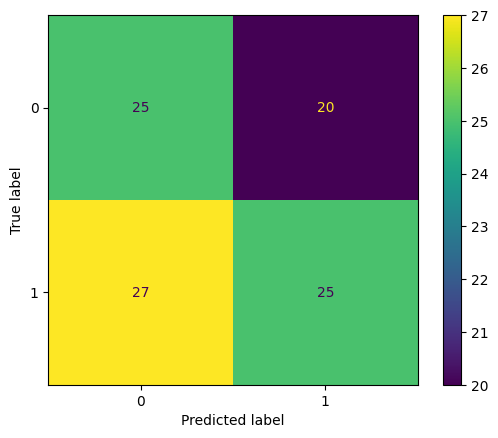

0.5154639175257731

In [ ]:
get_acc(model3, phone_data_combined, 20)

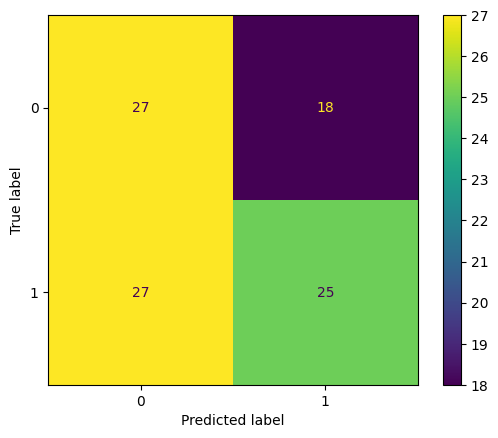

0.5360824742268041

In [ ]:
get_acc(model3, phone_data_combined, 5)

## Version 6

Used Version 4's model architecture and swapped the sisfall and phone collected data for testing and training respectively.

Output: Slight overfitting seen towards the end during training however the model definitely performs better on SisFall as compared with a similar experimentation in Version 3.

In [ ]:
model6 = Model2(6)



Epoch  0 
Training Loss         :  0.1 
Training Accuracy     :  0.78 
Validation Loss       :  0.14 
Validation Accuracy   :  0.61


Epoch  1 
Training Loss         :  0.13 
Training Accuracy     :  0.79 
Validation Loss       :  0.13 
Validation Accuracy   :  0.7


Epoch  2 
Training Loss         :  0.12 
Training Accuracy     :  0.9 
Validation Loss       :  0.2 
Validation Accuracy   :  0.66


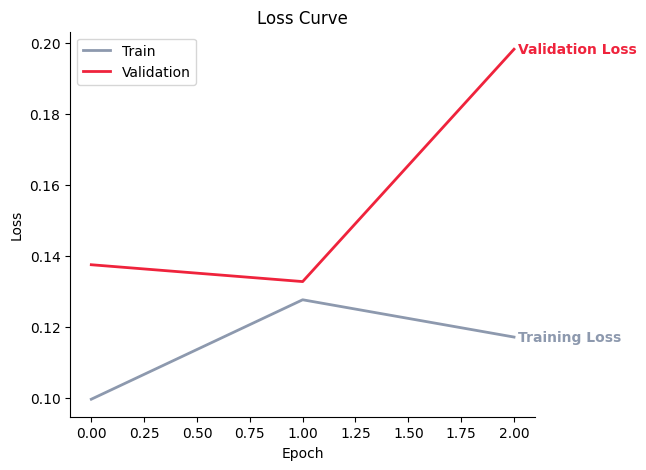

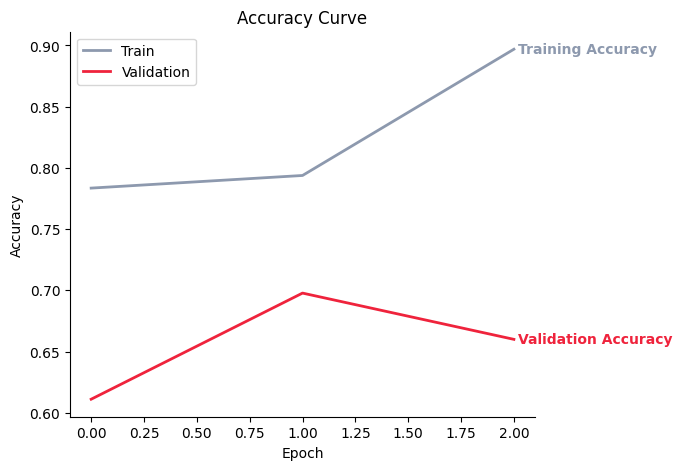

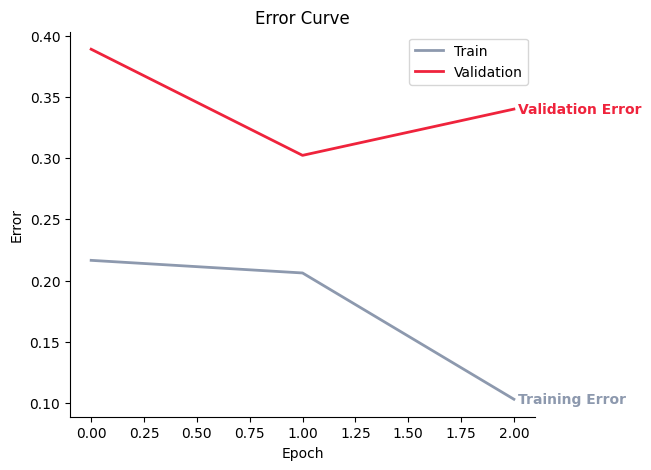

array([0.9997478 , 0.23689893, 0.03646717, 0.65742666, 0.14027959,
       0.97058386, 0.999295  , 0.10531574, 0.5845845 , 0.15124829,
       0.63412493, 0.19212903, 0.77216816, 0.8509757 , 0.37490377,
       0.9999001 , 0.03740557, 0.98650116, 0.10436477, 0.32892886,
       0.06056755, 0.3214788 , 0.6180922 , 0.13182904, 0.39650875,
       0.1008013 , 0.48818967, 0.28313035, 0.6126964 , 0.65943944,
       0.8055558 , 0.02838756, 0.9161538 , 0.7855842 , 0.2758467 ,
       0.9882062 , 0.25075915, 0.09416369, 0.44646236, 0.26609513,
       0.986912  , 0.22594292, 0.8287261 , 0.1070177 , 0.08193426,
       0.9995396 , 0.98495877, 0.05165867, 0.06407698, 0.05215277,
       0.9985514 , 0.07283593, 0.9021704 , 0.13562337, 0.9885119 ,
       0.37513003, 0.9998344 , 0.01732028, 0.11901044, 0.9994041 ,
       0.9997813 , 0.446111  , 0.2518883 , 0.72250015, 0.56596065,
       0.11598419, 0.9982451 , 0.8528834 , 0.87523586, 0.02604393,
       0.44429314, 0.0026652 , 0.6272357 , 0.20233405, 0.99663

In [ ]:
train(model6, phone_data_combined, test_data, 5, 0.01, 3)

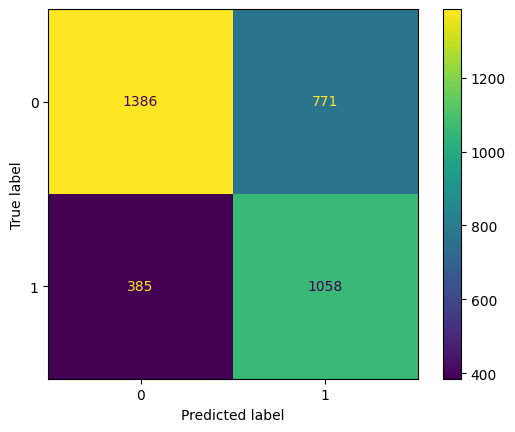

0.6788888888888889

In [ ]:
get_acc(model6, train_data, 5)

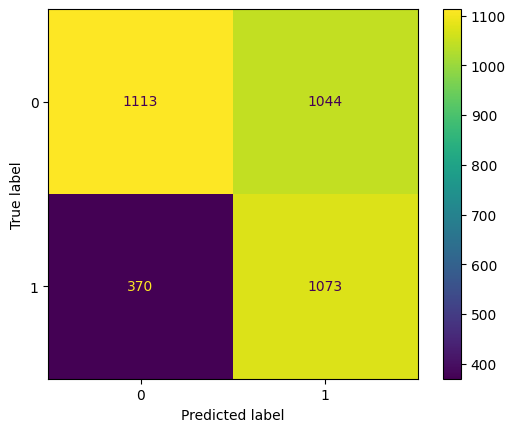

0.6072222222222222

In [ ]:
get_acc(model6, train_data, 2)

## Version 7

Passed in just accelerometer data due to higher accuracies obtained on accelerometer data based on research.

Output: Similar results as Version 6 were achieved on the unseen data. Model achieves high performance on SisFall Dataset.



In [ ]:
#Loading SisFall with only 2nd Accelerometer readings
import os

sisdata = []
sislabels = []
k = 1
for dir, _, files in os.walk('/content/gdrive/MyDrive/Preprocessed Data'):
  for file in files:
    file_df = pd.read_csv(os.path.join(dir, file))
    file_df = file_df.drop(['Timestamp', 'X_Acc_1', 'Y_Acc_1', 'Z_Acc_1', 'X_Gyro', 'Y_Gyro', 'Z_Gyro'], axis=1)
    file_np = np.array(file_df)
    file_np = np.array([file_np[i] for i in range(0, len(file_np)-20, 20)])
    file_np = file_np[:150]
    if len(file_np)<150:
      file_np = np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_np), 1)))))
    sisdata.append(file_np)
    if file[0] == 'F':
      sislabels.append(1)
    else:
      sislabels.append(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.vstack(np.array(sisdata)))

MinMaxScaler()

In [ ]:
sisdata_scaled = np.array([scaler.transform(np.array(sisdata[i])) for i in range(len(sisdata))])

In [ ]:
#Getting train, val, test data sets
import random
random.seed(42)
siscombined = (listOfTuples(torch.from_numpy(sisdata_scaled).to(torch.float), torch.from_numpy(np.array(sislabels)).to(torch.float)))
random.shuffle(siscombined)

In [ ]:
train_data = siscombined[:3600]
val_data = siscombined[3600:4050]
test_data = siscombined[4050:]

In [ ]:
phone_data = []
phone_labels = []

In [ ]:
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data/ADLs Phone'):
  for file in files:
    activity = file[:3]
    file_df = pd.read_csv(os.path.join(dir, file))
    cols = file_df.columns
    file_df['X_Acc'] = file_df['accelerometer_x'] * (-1)
    file_df['Y_Acc'] = file_df['accelerometer_y'] * (-1)
    file_df['Z_Acc'] = file_df['accelerometer_z'] * -1
    # file_df['X_Gyro'] = file_df['gyroscope_x'] * -180/3.14
    # file_df['Y_Gyro'] = file_df['gyroscope_y'] * -180/3.14
    # file_df['Z_Gyro'] = file_df['gyroscope_z'] * -180/3.14
    file_df = file_df.drop(cols, axis=1)
    file_df_np = np.array(file_df)
    # file_df_np = [np.vstack(file_df_np[i],  (10, 1)) for i in range(len(file_df_np))]
    if len(file_df_np)>150:
      file_df_np = file_df_np[:150]
    elif len(file_df_np)<150:
      file_df_np = np.vstack((file_df_np, np.tile(file_df_np[-1], (150-len(file_df_np), 1))))
    phone_data.append(file_df_np)
    phone_labels.append(0)

In [ ]:
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data/Falls Phone'):
  for file in files:
    activity = file[:3]
    file_df = pd.read_csv(os.path.join(dir, file))
    cols = file_df.columns
    file_df['X_Acc'] = file_df['accelerometer_x'] * (-1)
    file_df['Y_Acc'] = file_df['accelerometer_y'] * (-1)
    file_df['Z_Acc'] = file_df['accelerometer_z'] * -1
    # file_df['X_Gyro'] = file_df['gyroscope_x'] * -180/3.14
    # file_df['Y_Gyro'] = file_df['gyroscope_y'] * -180/3.14
    # file_df['Z_Gyro'] = file_df['gyroscope_z'] * -180/3.14
    file_df = file_df.drop(cols, axis=1)
    file_df_np = np.array(file_df)
    # file_df_np = [np.vstack(file_df_np[i],  (10, 1)) for i in range(len(file_df_np))]
    if len(file_df_np)>150:
      file_df_np = file_df_np[20:170]
    elif len(file_df_np)<150:
      file_df_np = np.vstack((file_df_np, np.tile(file_df_np[-1], (150-len(file_df_np), 1))))
    phone_data.append(file_df_np)
    phone_labels.append(1)

In [ ]:
phone_data_scaled = scaler.transform(np.vstack(np.array(phone_data))).reshape((97, 150, 3))

In [ ]:
phone_data_combined = (listOfTuples((torch.from_numpy(phone_data_scaled)).to(torch.float), torch.from_numpy(np.array(phone_labels)).to(torch.float)))
random.shuffle(phone_data_combined)

In [ ]:
model7 = Model2(3)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.96 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


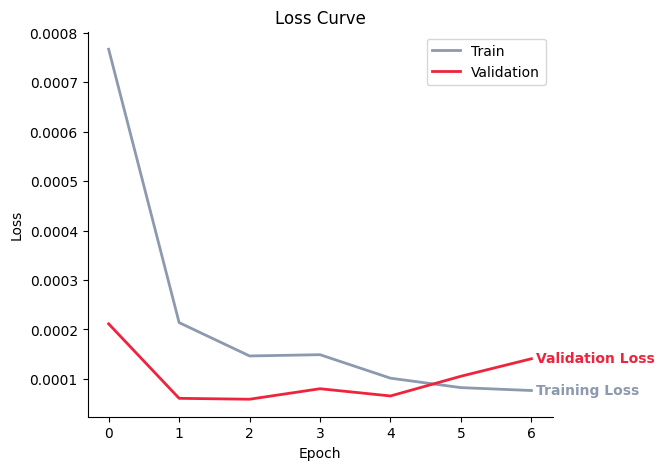

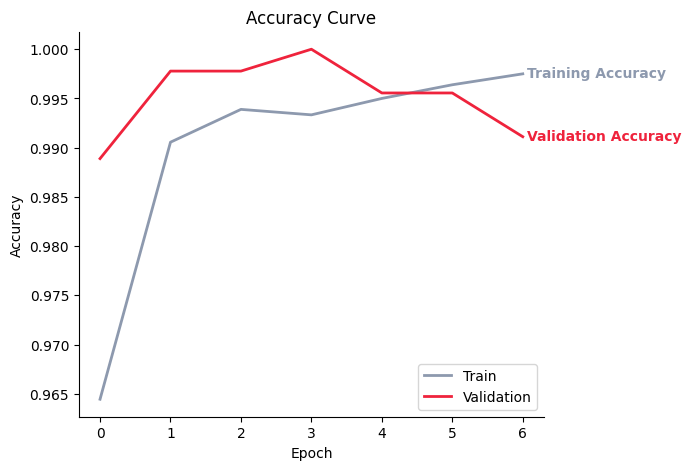

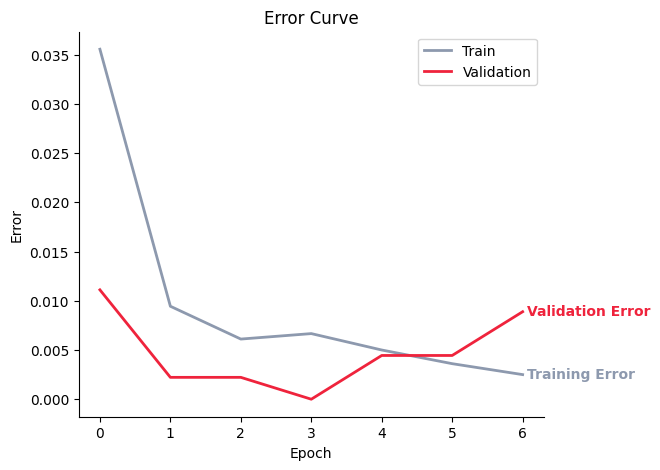

array([5.80318047e-05, 1.29102739e-06, 9.99970436e-01, 9.99063313e-01,
       1.00000000e+00, 9.99980688e-01, 7.34231799e-05, 3.87297216e-04,
       1.82203130e-05, 1.00000000e+00, 8.83593748e-04, 9.99885798e-01,
       3.71688543e-07, 9.99979019e-01, 8.67235576e-05, 4.10652487e-03,
       2.37654080e-04, 4.99850279e-03, 4.07092437e-14, 2.06516066e-08,
       9.99970317e-01, 3.83929757e-04, 9.49376285e-01, 9.99917746e-01,
       9.99871850e-01, 9.99977231e-01, 1.56755748e-04, 1.71686421e-04,
       1.00000000e+00, 9.99935150e-01, 9.99080896e-01, 9.99996424e-01,
       9.99843597e-01, 1.18173593e-05, 9.99013901e-01, 2.63271708e-04,
       9.99973893e-01, 9.99999881e-01, 2.53133612e-06, 2.78034917e-04,
       5.93948702e-04, 2.98930786e-06, 9.77771051e-05, 9.99997973e-01,
       1.21655321e-05, 2.23554875e-04, 1.00000000e+00, 9.99990702e-01,
       9.82859433e-01, 8.46487237e-05, 1.22745725e-04, 9.94422473e-04,
       4.19603311e-05, 9.99864578e-01, 4.51558044e-08, 9.99725163e-01,
      

In [ ]:
train(model7, train_data, val_data, 150, 0.01, 7)

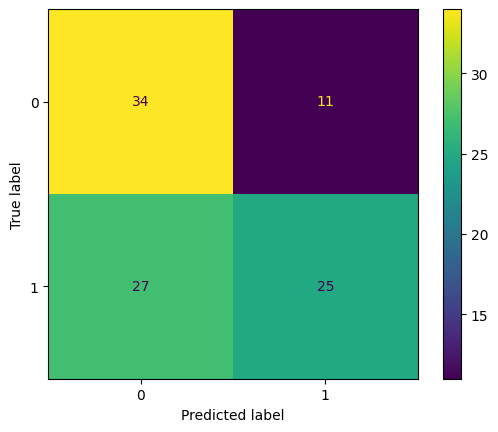

0.6082474226804124

In [ ]:
get_acc(model7, phone_data_combined, 100)

**Key takeaways from training on raw sensor data**

Batch size impacts model performance on different batches (as seen in Version 2) but even ignornig this, it seems as if the model cannot generalize patterns it found in SisFall to the Phone Collected Data or vice-versa. This could be due to multiple reasons:

1. Downsampling SisFall causing loss of data
2. Difference in the sensitivity, accuracy and ranges between phone collected data and SisFall data.

Overall, we can say that based on the tests we have conducted, the model is not suited for working directly on raw sensor data, highlighting the need for the Data Preprocessing and Window Sampling/Feature Extraction done in version 2.

**Another Note:**
There was no Version 5 and the variable names for versions 4 and 3 got interchanged.
Apologies for the incorrect naming convention!

We also haven't saved the paths to the models as we decided against using this form of sensor data input!